# Week 6 Project Introduction - Data Pipeline

This week's project gives a brief overview into Data Engineering by extracting tweets from twitter and perform a Sentiment analysis on them. We separate the whole workflow in small managable parts where all are **connected to each other** and can be launched or stopped with a single command.

The **data** this week will be real-time tweets what we access using the **Twitter API**.

There are quite a few **new concepts** that we will cover this week:
- [Application Programming Interfaces (APIs)](https://spiced.space/stationary-sriracha/ds-course/chapters/project_pipeline/api/README.html)
- [Docker](https://spiced.space/stationary-sriracha/ds-course/chapters/project_pipeline/docker/README.html)/[Docker-Compose](https://spiced.space/stationary-sriracha/ds-course/chapters/project_pipeline/docker/compose.html)
- NoSQL Databases (we use [MongoDB](https://spiced.space/stationary-sriracha/ds-course/chapters/project_pipeline/mongodb/README.html))
- [ETL (Extract-Transform-Load](https://spiced.space/stationary-sriracha/ds-course/chapters/project_pipeline/etl/README.html)
- [Sentiment Analysis](https://spiced.space/stationary-sriracha/ds-course/chapters/project_pipeline/sentiment_analysis.html)

The animation below shows this week's workflow as an illustrated analogy:

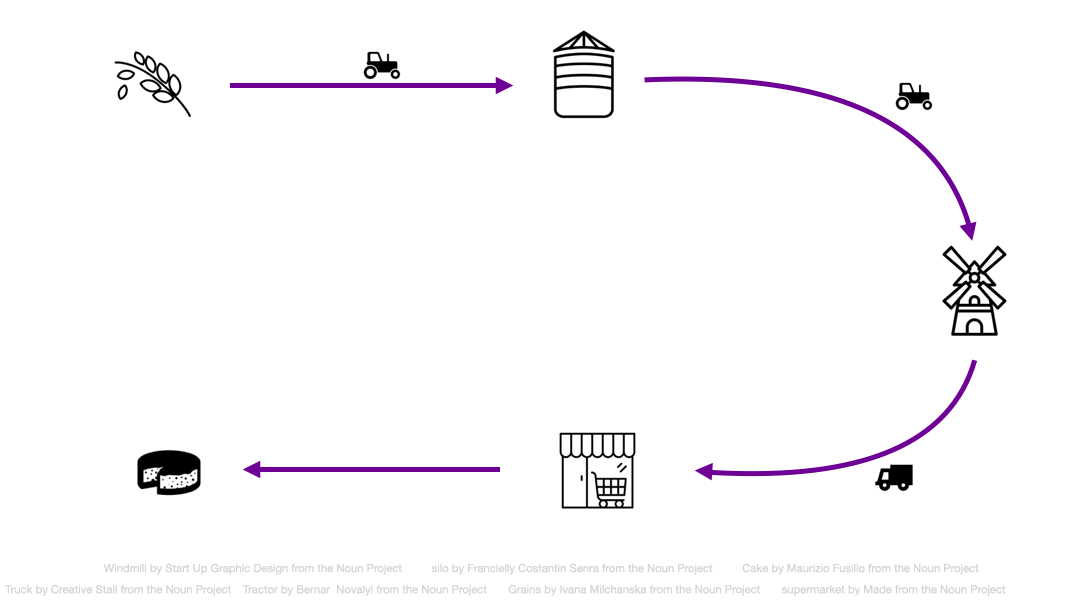

In [1]:
#Pipeline animation
from IPython.display import Image, display
display(Image(filename="intro_pipeline.gif", format='gif'))

# To run it again, run the cell again!

Manage and run and entire data stream / “pipeline”, where each component of the pipeline is its own, isolated [“microservice”](https://aws.amazon.com/microservices/) managed by Docker Compose.

In simpler terms: Run a complex, interconnected piece of software (composed of 5 individual moving parts) in such a way that all components run continuously and talk to each other, and the whole pipeline can be launched (and stopped) with a single command.

# API - Application Programming Interfaces

Why?
- APIs are the data source for the data pipeline we are building this week. 
- In general, APIs are a great data source.

What?

From the course materials:

- An API, short for Application Programming Interface, is a concept used to describe –essentially – a piece of intermediary software (the interface) that facilitates communication between 2 other pieces of software (the applications).
- This is a very general definition. When we talk about APIs, we mostly refer to Web APIs.
- API = website providing data in a format more machine-readable than HTML.
 - We still submit an HTTP request though, e.g. with the   library.
- [Rest](https://www.redhat.com/en/topics/api/what-is-a-rest-api#:~:text=A%20REST%20API%20(also%20known,by%20computer%20scientist%20Roy%20Fielding.) / RESTful APIs:
 - REST = representational state transfer.
 - They conform to particular architectural standards — software developers creating them, had to pay attention to certain things, and design them in certain way; it's a way of standardizing APIs some. "Best practices" for designing APIs.

### What makes a Web API better than scraping? 

- We still send HTTP `requests` but this time we get different data back!
- A Web API provides data in a **more machine-readable format** than HTML (mostly JSON) 
    - In week 4: we send an HTTP request, and get back HTML. 
    - Now: we send an HTTP request, get back JSON.
- With an API we know we are definitely allowed to access the data we are using, and on what terms
- For larger data providers (eg. Twitter) there are often helper libraries (+ documentation!) that make the process even easier. This week we will be using `tweepy`.

# Example of testing an API 

In [2]:
"""
Berlin public transport API
"""

import requests

BASE_URL = 'https://v5.vbb.transport.rest'

# find a station
name = 'moritzplatz'
url = f"{BASE_URL}/locations?poi=false&addresses=false&query={name}"
station_id = requests.get(url).json()[0]['id']

# look up departures
print('\nNext connections from U Moritzplatz:\n')

url = f'{BASE_URL}/stops/{station_id}/departures?duration={10}'

j = requests.get(url).json()

for e in j:
    print(e['plannedWhen'][11:-9], '  ', e['line']['name'], e['direction'])


Next connections from U Moritzplatz:

13:52    M29 U Wittenbergplatz
13:53    U8 S+U Hermannstr.
13:54    M29 U Hermannplatz
13:57    M29 Grunewald, Roseneck
13:58    U8 S+U Hermannstr.
13:59    M29 U Hermannplatz
13:58    U8 S+U Wittenau
14:03    U8 S+U Hermannstr.
14:04    M29 U Hermannplatz
14:02    M29 U Wittenbergplatz
14:03    U8 S+U Wittenau


# Tweepy

In [3]:
#!pip install tweepy

In [4]:
# Connect to twitter API
import tweepy
import twitter_keys
client = tweepy.Client(bearer_token=twitter_keys.Bearer_Token)

### Look up a user by their user name

(For `user_fields` parameters check here https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/user

In [ ]:
gavin = client.get_user(username='gavofyork',user_fields=['name','id','created_at'])
user = gavin.data
print(gavin)

We can get all the data from our user as a dictionary:

In [ ]:
dict(user)

... or get out individual pieces of information:

In [ ]:
print(f'the user with name {user.name} and ID {user.id} created their twitter account on {user.created_at}')

### Look at a user's timeline
(for `tweet_fields` parameters check here https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/tweet)

In [ ]:
gavin_tweets = client.get_users_tweets(id=user.id, tweet_fields=['id','text','created_at'],max_results=100)
print(gavin_tweets.data)

We can write the tweets to a text file:

In [ ]:
for tweet in gavin_tweets.data:
    print(f"The user {user.name} at {tweet.created_at} wrote: {tweet.text}\n")
    file = open('gavin_tweets.txt',mode='a')
    file.write('\n\n'+tweet.text)
    file.close()

### Using the `Paginator` object from `tweepy`: 
Getting more than 100 tweets at a time

#### Search recent tweets

In [ ]:
# - means NOT
search_query = "#testing_tweepy -is:retweet -is:reply -is:quote -has:links"

#option to extract tweets of a particular language add `lang` parameter eg lang:de

cursor = tweepy.Paginator(
    method=client.search_recent_tweets,
    query=search_query,
    tweet_fields=['author_id', 'created_at', 'public_metrics'],
    user_fields=['username'],
).flatten(limit=200)

for tweet in cursor:
     print(tweet.data)


## References
Twitter API docs:
- https://docs.tweepy.org/en/stable/v2_pagination.html?highlight=paginator#tweepy.Paginator
- https://docs.tweepy.org/en/stable/client.html#tweepy.Client.get_users_tweets
- https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/tweet
- https://docs.tweepy.org/en/stable/client.html#tweepy.Client.search_recent_tweets
- https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query


# Optional
To get tweets as continous streams 
check out the official github [link](https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/Filtered-Stream/filtered_stream.py) by twitter developers